In [1]:
import warnings
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.filterwarnings('ignore')

rs = 132
dataset = pd.read_csv('./data/dataset.csv', dtype={"股票代码": "object"})
others = pd.read_csv('./data/un_unit.csv', dtype={"股票代码": "object"})
# dataset.set_index('股票简称', inplace=True)
dataset.set_index(['股票代码', "截止日期"], inplace=True)
features = [
    '净资产收益率(%)', '资产报酬率(%)', 'EBITDA率(%)', '营业收入增长率(%)', '成本费用利润率(%)', '总资产周转率(%)', '应收账款周转率(%)', '存货周转率(%)', '营业周期', '现金资产比率(%)', '技术人员占比(%)', '研发营收比(%)', '发明专利申请数', '数字化软硬件投入比(%)', '数字化战略导向前瞻性', '数字化战略导向持续性', '数字化战略导向广度', '数字化战略导向强度', '数字发明专利', '数字国家级奖项', '数字创新论文', '数字创新标准', '数字创新资质', '管理层数字职务设立', '两权分离率(%)', '数字人力计划投入', '数字资本计划投入', '科技创新基地建设', '员工人均营收比(%)', '提供岗位增长率(%)', '员工收入增长率(%)', '社会责任报告质量', '供应链合作伙伴', '数字化供应链覆盖度', '客户集中度(%)', '供应商集中度(%)'
]
label_name = 'score'
# 获取数据集和标签值
y : pd.Series = dataset[label_name]
X : pd.DataFrame = dataset[features].copy(deep=True).astype("float")
# 数据预处理：1.极差标准化；2.数据集划分。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

params = {"iterations": 300, "learning_rate": 0.36, "depth": 2, "l2_leaf_reg": 0.21, 'bagging_temperature': 0.1, "border_count": 49}
model = CatBoostRegressor(random_state=rs, verbose=0, train_dir=None, allow_writing_files=False, **params)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("最优模型选择为 {0},其各项表现分别为：mse:{1:.2%}  rmse:{2:.2%}  mae:{3:.2%}   r2:{4:.2%}".format("CatBoost", mse,np.sqrt(mse), mae, r2))

最优模型选择为 CatBoost,其各项表现分别为：mse:0.00%  rmse:0.33%  mae:0.15%   r2:98.46%


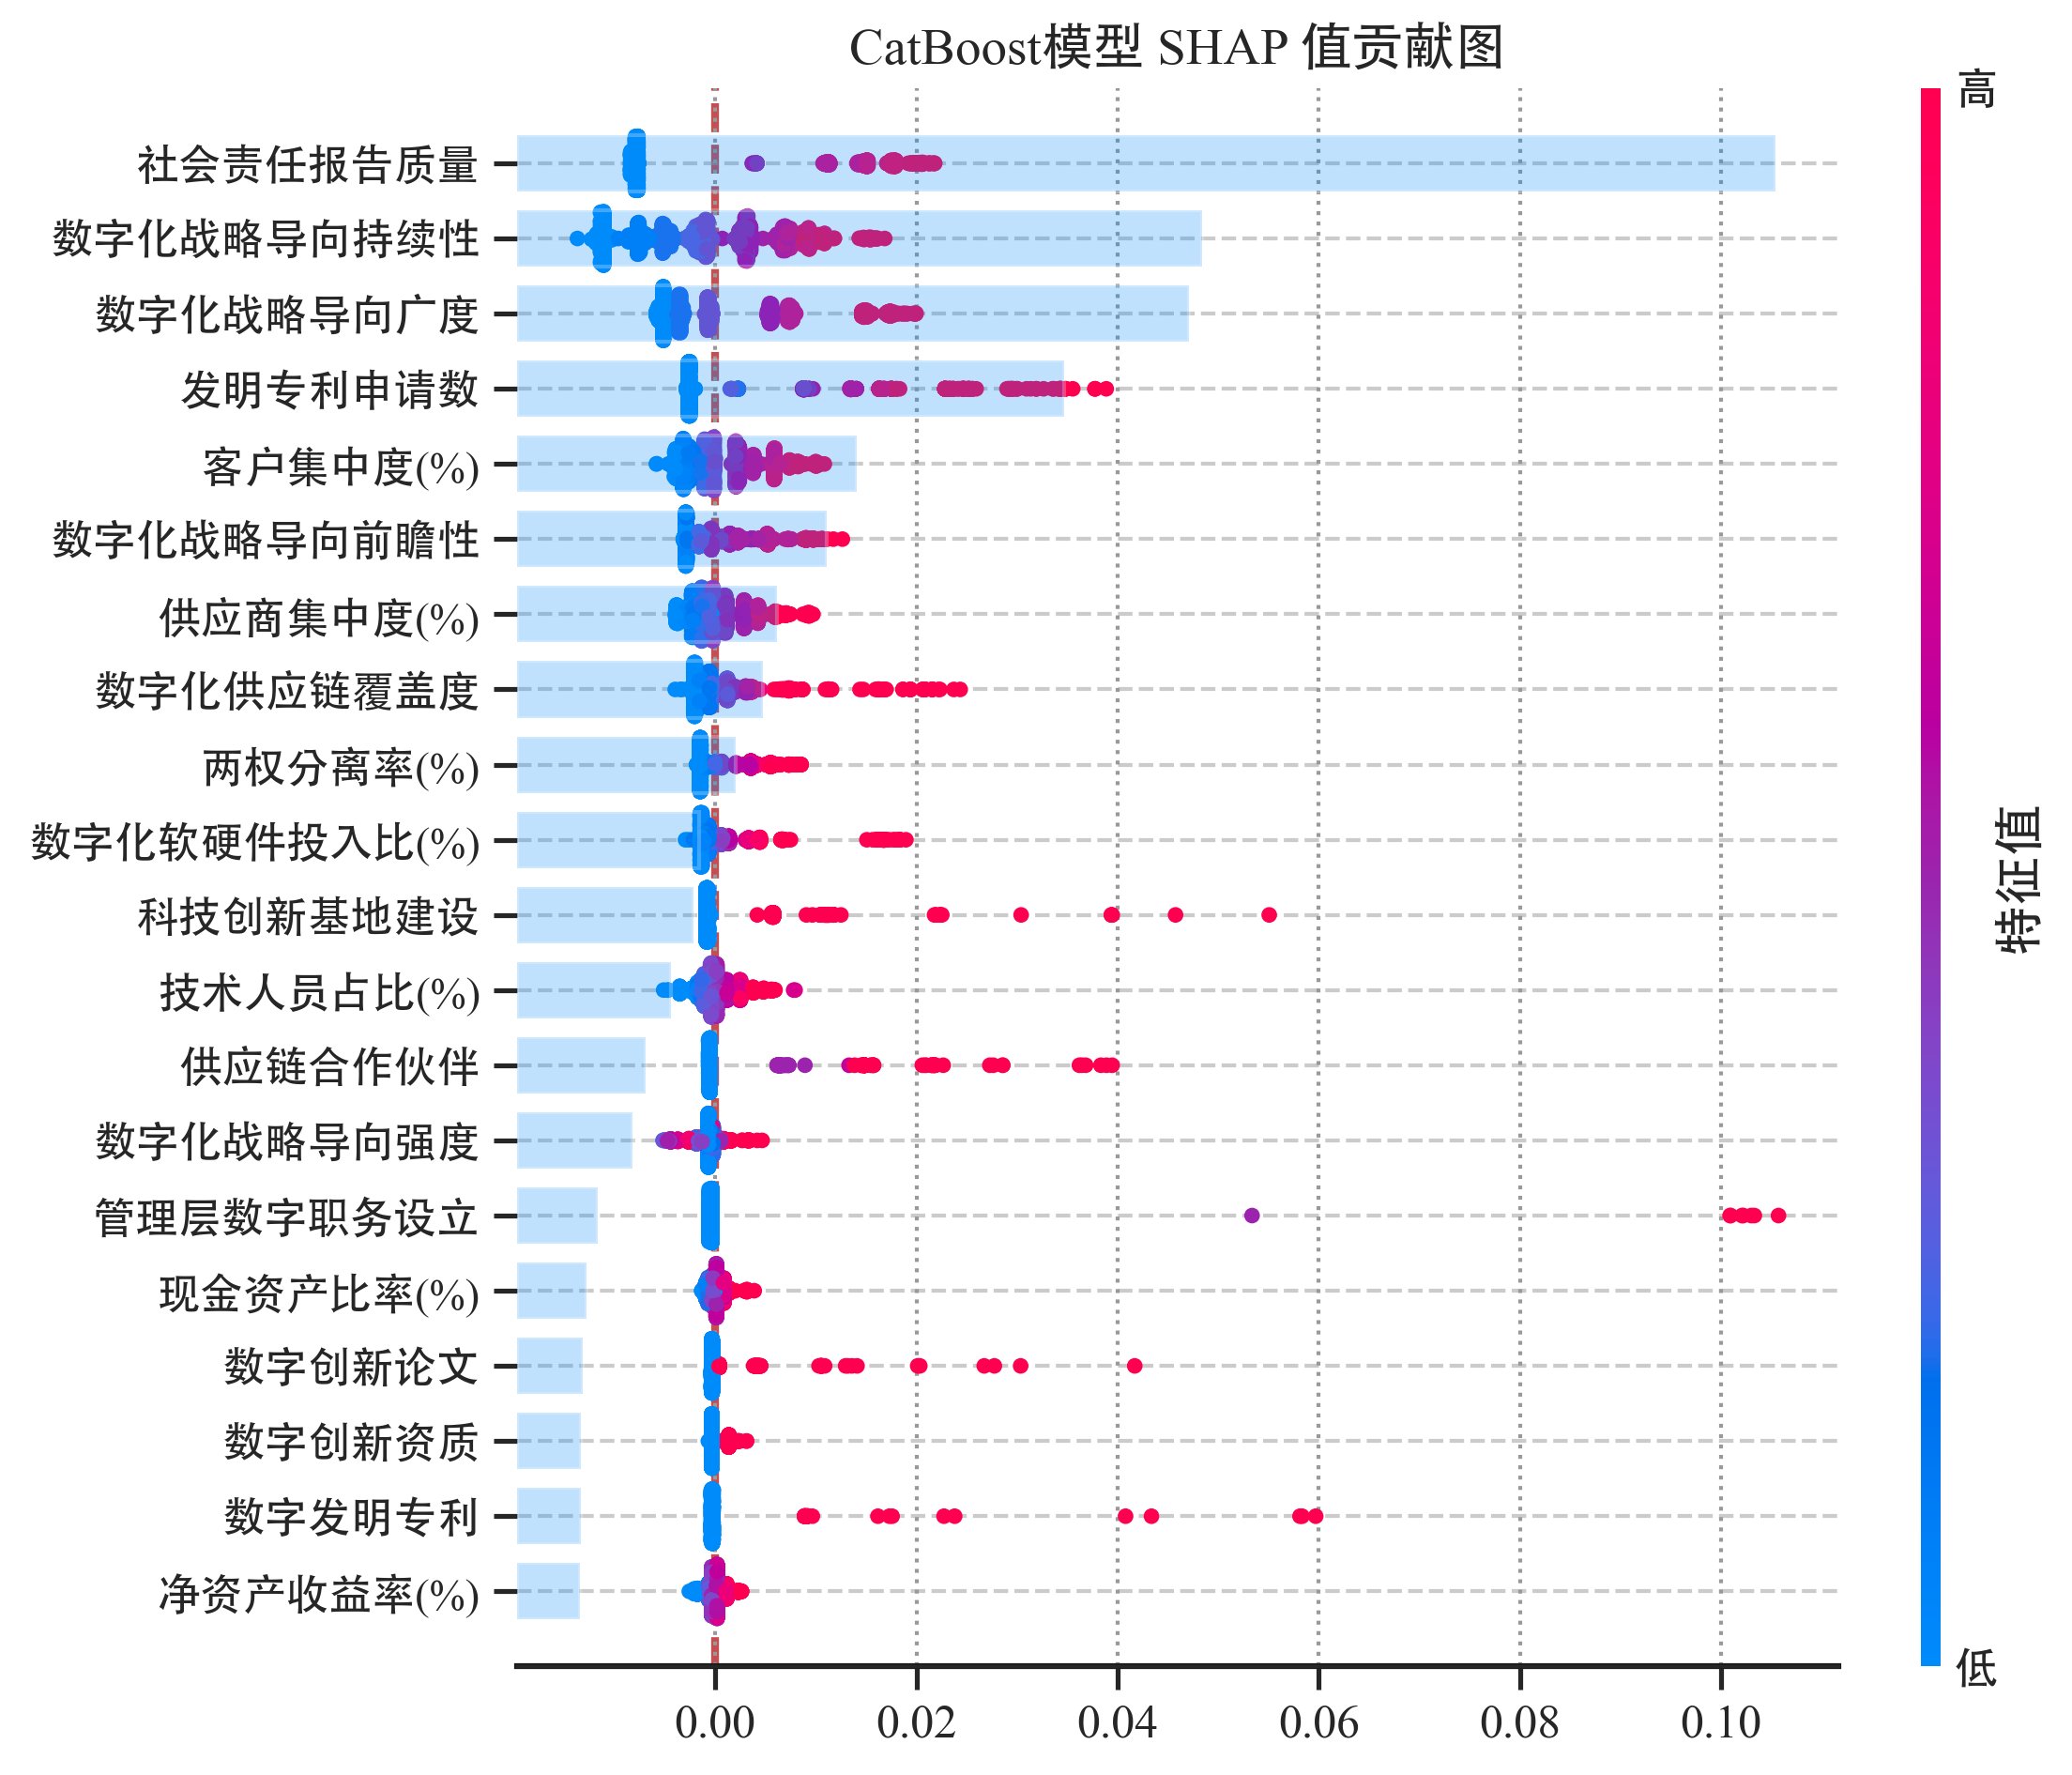

In [4]:
# 基于shap的全局解释
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from utils.methods import feature_importance_plot
#  'SimSun', # 'SimSun' 为宋体
sns.set(context='notebook', style='ticks', font_scale=1.1)
sns.set_style("ticks", {'axes.grid':True, "grid.color": ".6", "grid.linestyle": ":"})
plt.rcParams['font.family'] = ['Times New Roman','Heiti TC', 'Heiti TC',] 
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
from utils.methods import shap_summary_plot, dependency_plot


shap.initjs()
#  ======= SHAP解释器创建 =======
explainer = shap.TreeExplainer(model)
# 这个用于解释神经网络等深度学习模型
# explainer = shap.DeepExplainer(model, X_train_s)
shap_values = explainer.shap_values(X_test_s)
# ======= 全局特征重要性（特征贡献度） =======
shap_summary_plot(shap_values, X_test_s, feature_names=features, title="CatBoost模型 SHAP 值贡献图",figsize=(8, 6.5), savepath="./assert/imgs/shap_values.png")

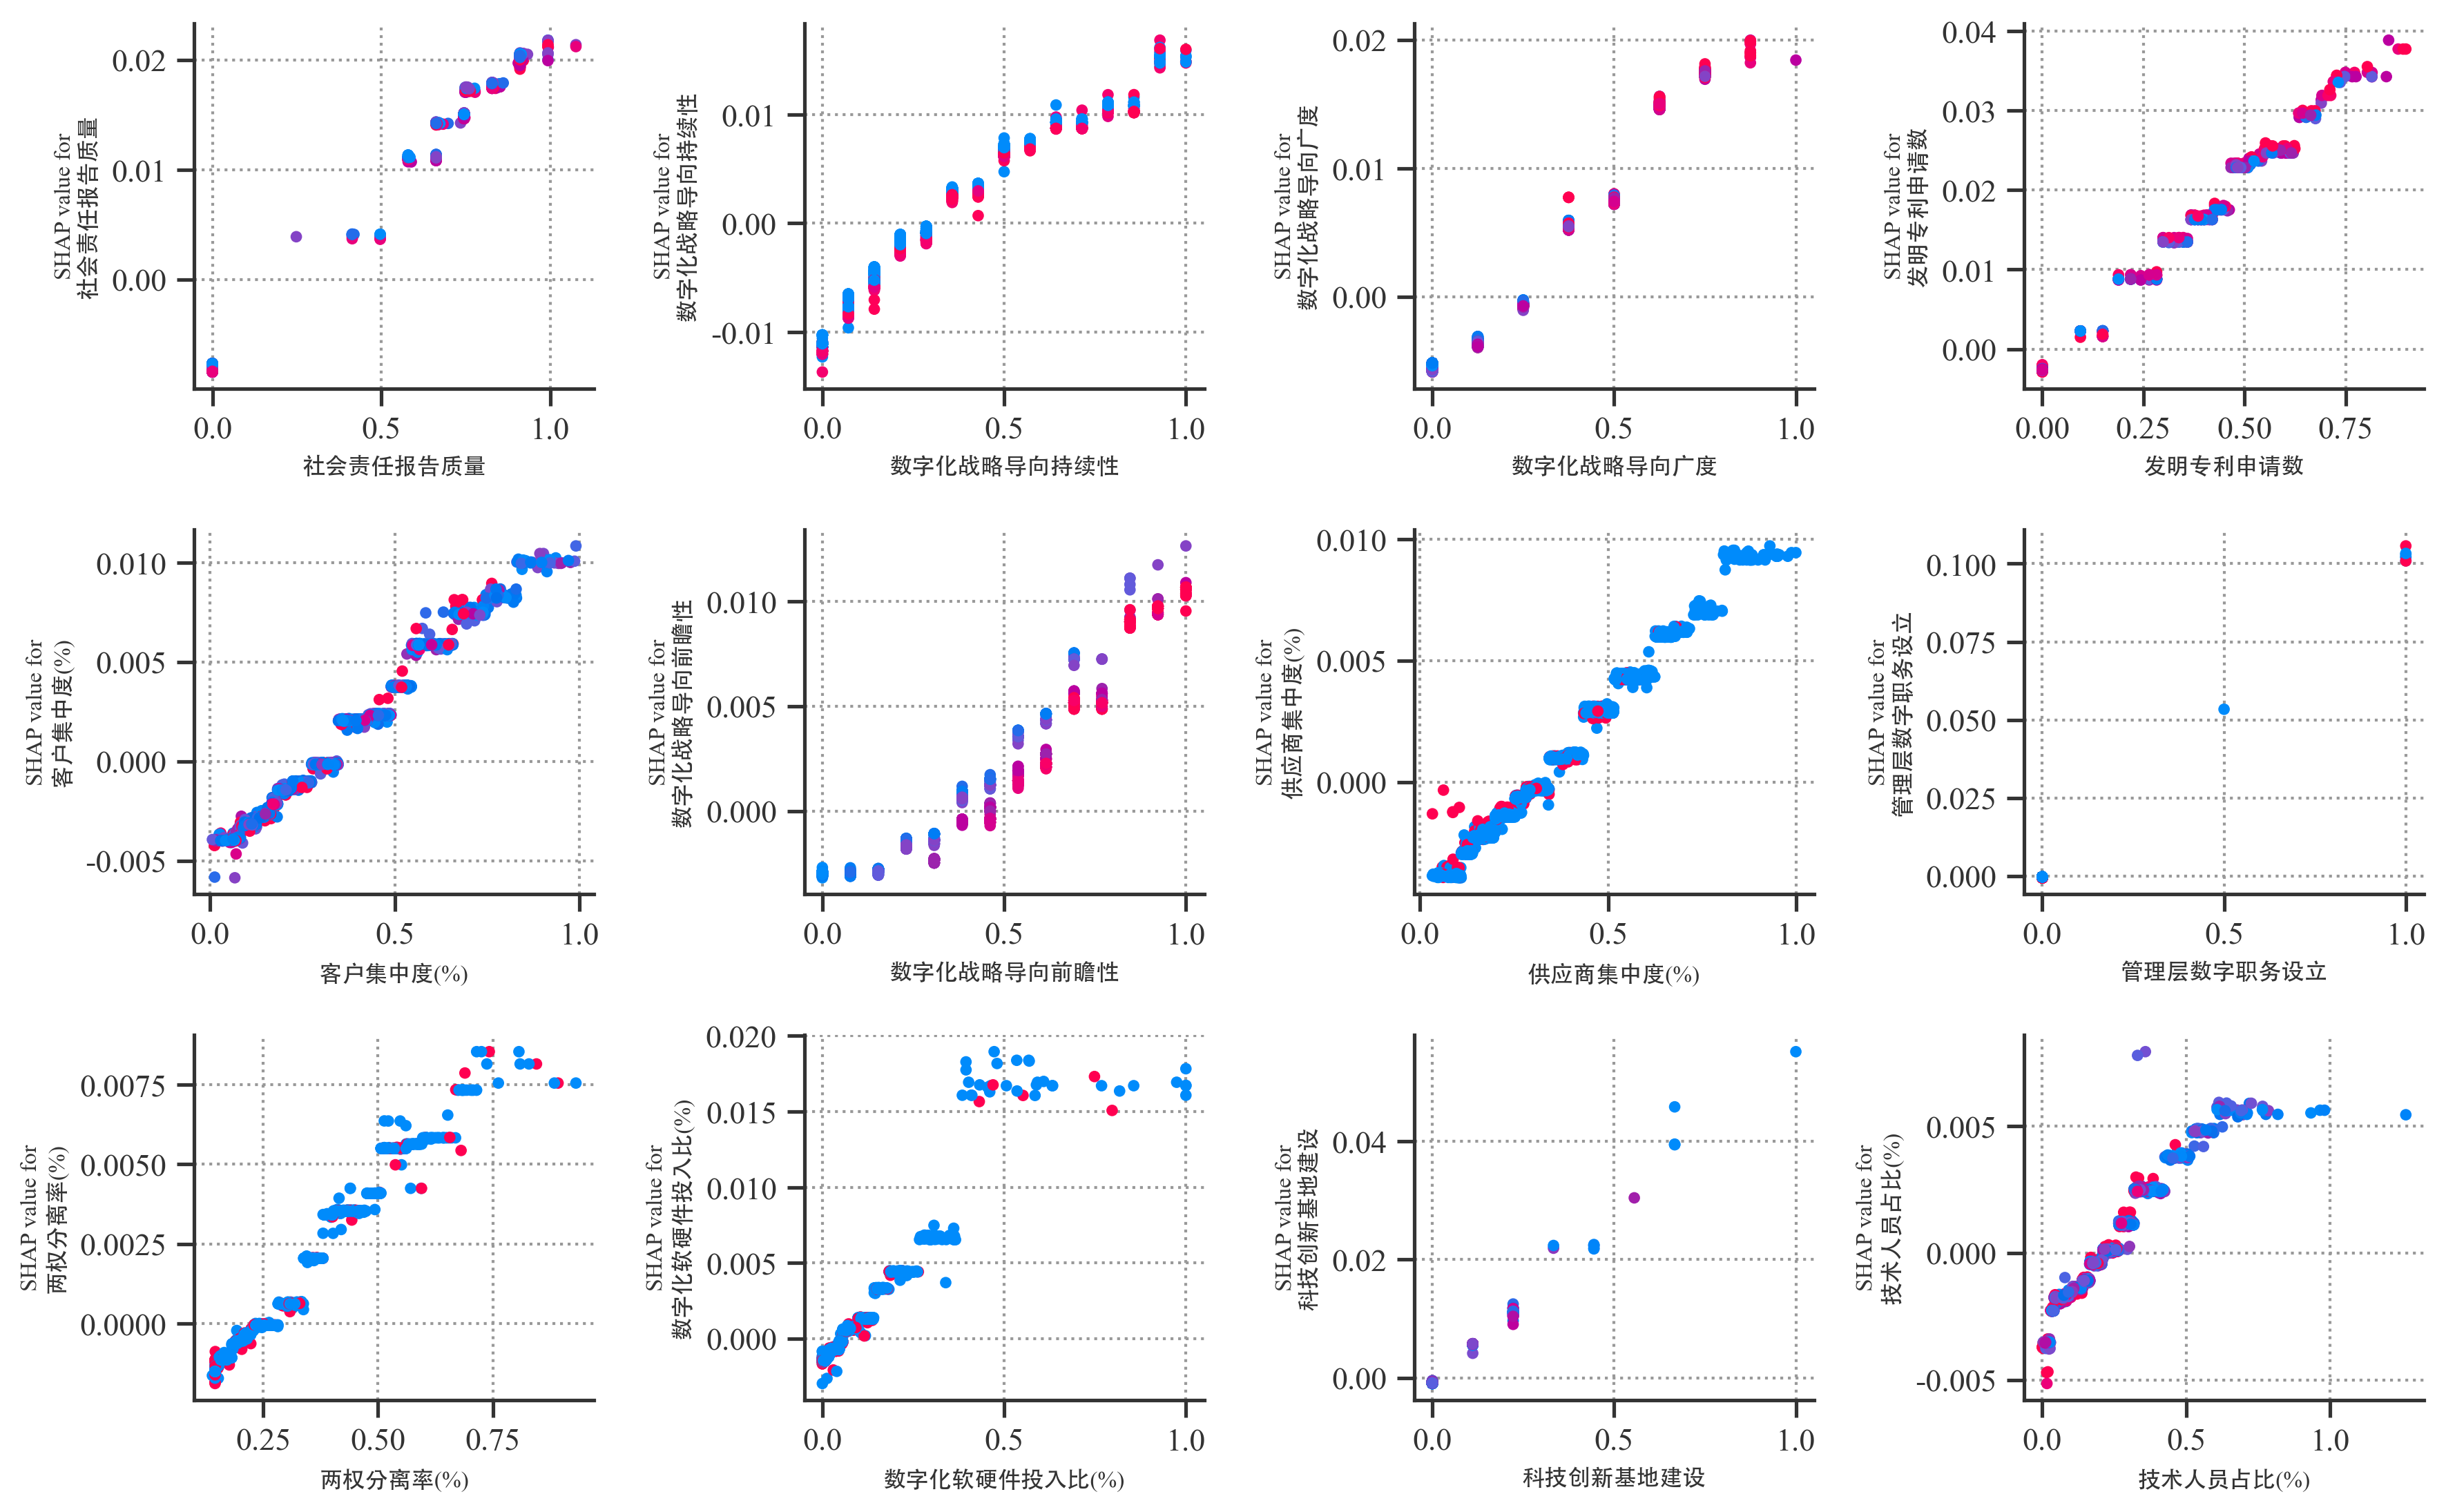

In [10]:
names = [
    '社会责任报告质量',  '数字化战略导向持续性', '数字化战略导向广度','发明专利申请数',
    '客户集中度(%)','数字化战略导向前瞻性', '供应商集中度(%)','管理层数字职务设立',
    "两权分离率(%)", "数字化软硬件投入比(%)", '科技创新基地建设',"技术人员占比(%)"
]
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 7.5), dpi=300)
for i,name in enumerate(names):
    dependency_plot(name, shap_values, X_test_s, features, ax=axs[i //4, i % 4])
fig.tight_layout()
plt.savefig(f'./assert/imgs/shap关键变量偏依赖关系图.png', dpi=300, bbox_inches='tight', pad_inches=0.0,transparent=True)
plt.show()
# shap.dependence_plot('社会责任报告质量', shap_values, X_ana)  # , interaction_index="HouseAge"

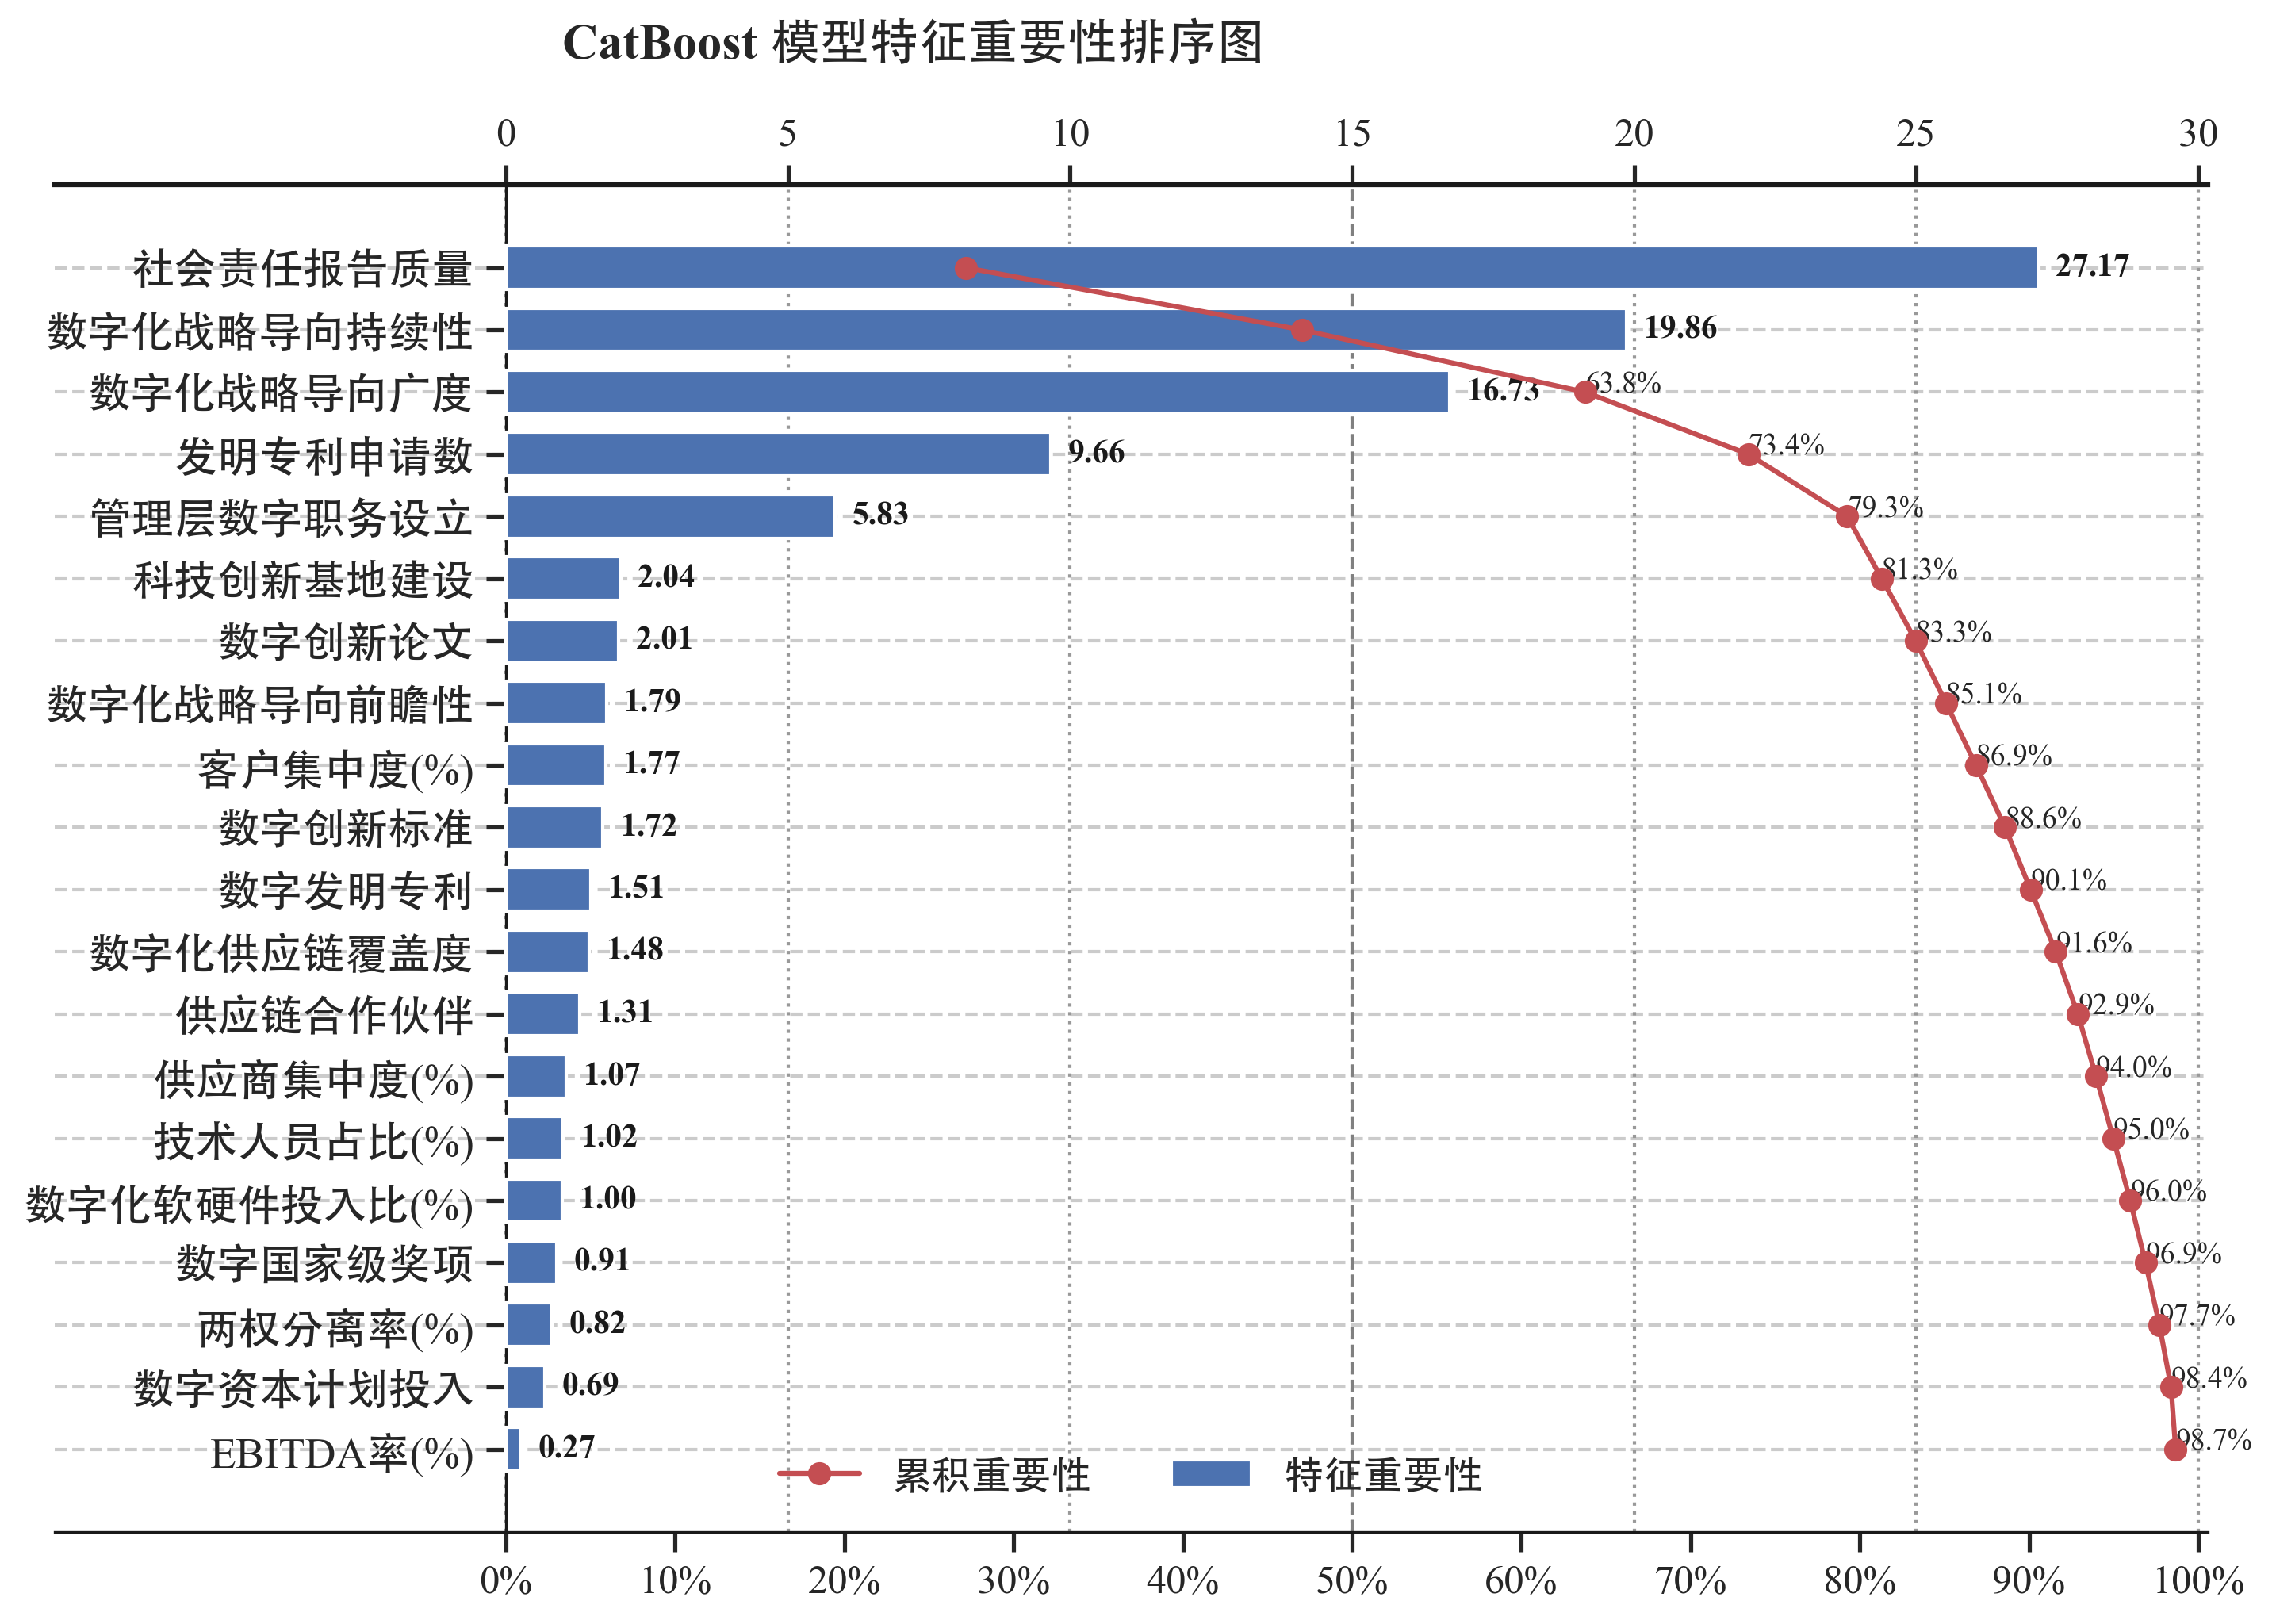

In [12]:
weight = pd.DataFrame(model.feature_importances_, columns=['特征重要性'] ,index=features).sort_values('特征重要性', ascending=False) 
feature_importance_plot(weight, save_path='assert/imgs/catboost_特征重要性图.png')

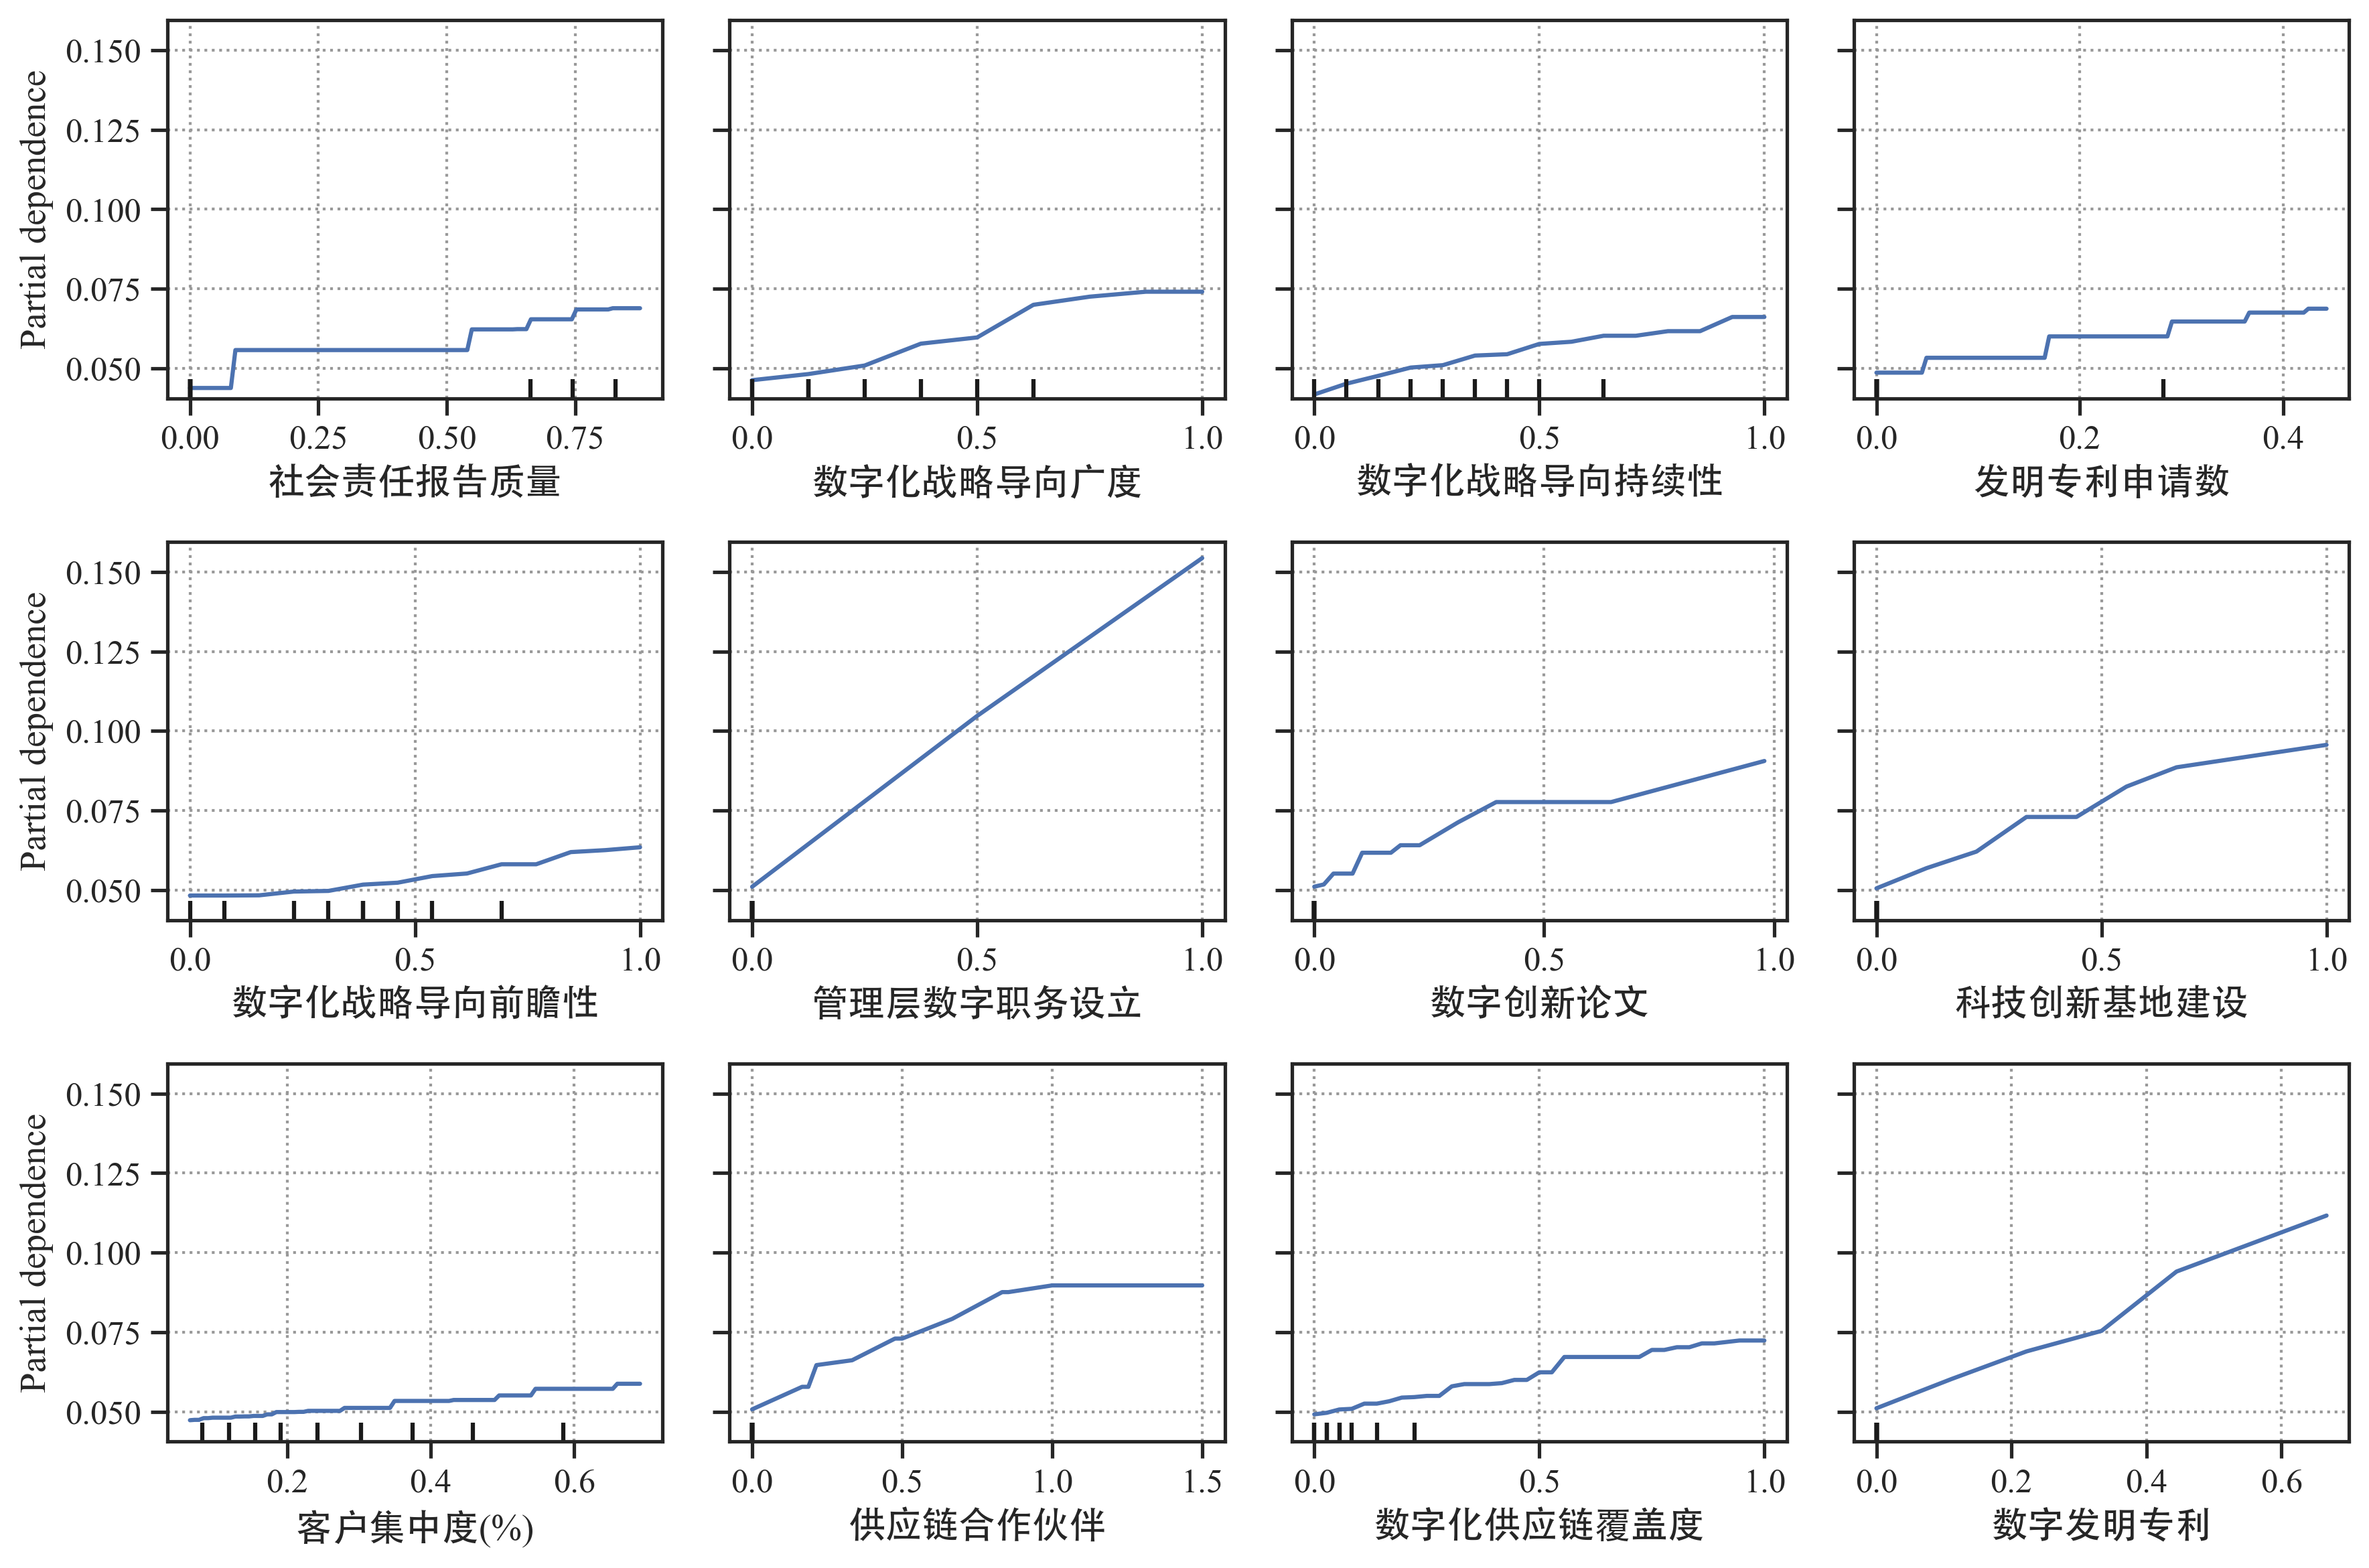

In [16]:
from sklearn.inspection import PartialDependenceDisplay



# 可视化偏依赖关系
names = [
    '社会责任报告质量', '数字化战略导向广度', '数字化战略导向持续性', '发明专利申请数',
    '数字化战略导向前瞻性', '管理层数字职务设立', '数字创新论文', '科技创新基地建设',
    '客户集中度(%)', '供应链合作伙伴', '数字化供应链覆盖度', '数字发明专利',
]
X_ana = pd.DataFrame(X_test_s, columns=features)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 8), dpi=300)
PartialDependenceDisplay.from_estimator(model, X_ana, names, n_cols=4, n_jobs=-1, ax=ax)

# plt.title('CatBoost模型关键变量偏依赖关系图')
plt.tight_layout()
plt.savefig(f'./assert/imgs/关键变量偏依赖关系图.png', dpi=300, bbox_inches='tight', pad_inches=0.0,transparent=True)
plt.show()

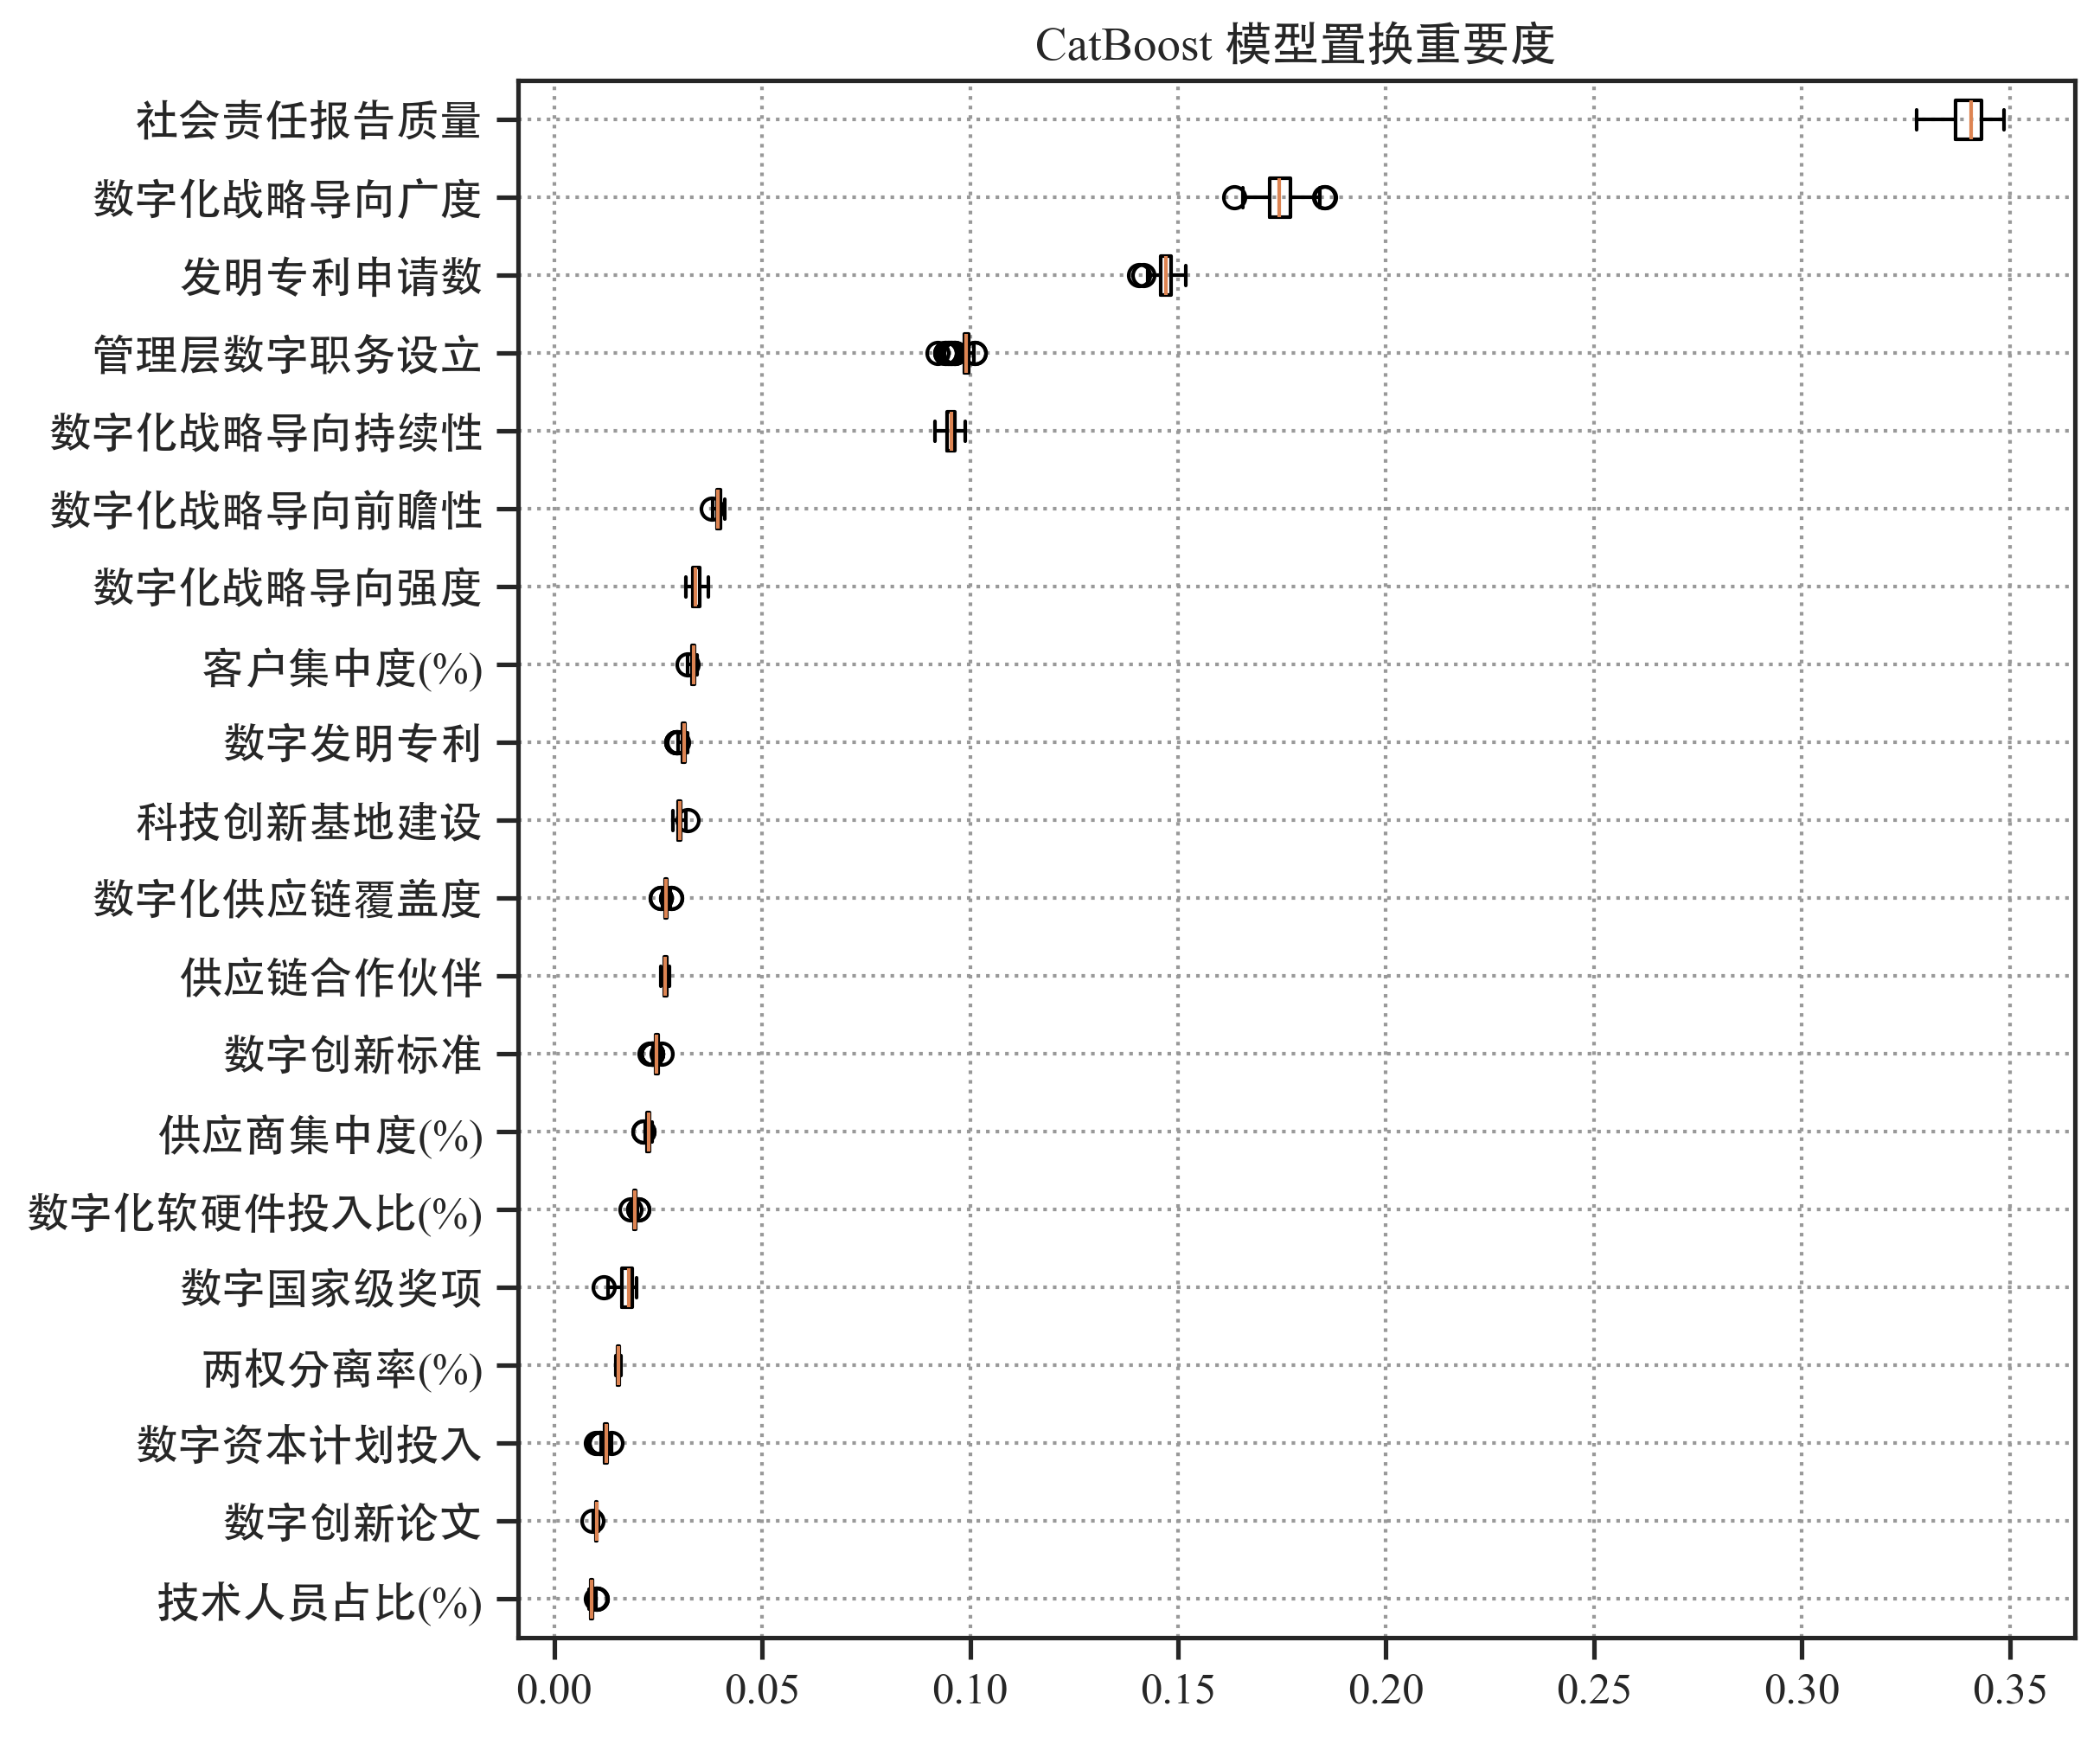

In [14]:
from sklearn.inspection import permutation_importance


# n_repeats=20：进行50次随机替换
# Bunch_result:[importance(置换重要度),importance_mean（置换重要度均值）,importance_std（置换重要度标准差
Bunch_result = permutation_importance(model, X_train_s, y_train, n_repeats=200, random_state=42, n_jobs=-1)
# 建立排序前后的映射
Bunch_index = Bunch_result.importances_mean.argsort()
nlabels = [features[i] for i in Bunch_index]
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])
# Bunch_index = Bunch_result.importances_mean.argsort()
ax.boxplot(Bunch_result.importances[Bunch_index].T[:,-20:], vert=False, labels=nlabels[-20:])  #  
ax.set_title('CatBoost 模型置换重要度')
plt.savefig('./assert/imgs/节点重要性分析.svg', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:

import numpy as np
# from types import MethodType
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'simsun' # Times New Roman
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

# font = {"fontsize":10, "fontfamily": "Songti SC"}  
# font = {"fontsize":10, "fontfamily": "simsun"} 
# score = lambda self, X, y: self.evaluate(X, y, verbose=0)[1]

# (1)计算权重特征重要度；
# model = models.load_model("./assert/bp_keras_model.keras")
# model.score = MethodType(score, model)
# layer_weights = model.layers[0].get_weights()[0]
# feature_importance = np.mean(np.abs(layer_weights), axis=1)  # 取绝对值的平均值

In [ ]:
# 检验神经网络模型对 2010 年 164 家上市公司经营绩效的拟合效果，计算神经网络绩效评 价得分与经营绩效实际得分的 Pearson 相关系数，其值为 0.966，均方误差为 0.0013，平均绝 对误差为 0.027，平均相对误差为 3.89%，由此可知 BP 神经网络评价模型对 2010 年民营制造 业上市公司经营绩效的拟合效果非常好。从排名差异来看，由表 4.4 可知，排名前五的上市 公司实际排名和预测排名完全一致，排名后五的上市公司两者排名相差较小；检验排名的次 序相关程度，计算 Spearman 次序相关系数，其值为 0.922，说明预测排名与实际排名基本一 致，因此可以认为 BP 神经网络评价模型对 2010 年 164 家民营制造业上市公司经营绩效的拟 合效果非常好。


shap.initjs()
explainer = shap.DeepExplainer(model, X_train_s)
shap_values = explainer.shap_values(X_test_s)
_shap_values = shap_values.T[0].T

# fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# bars = ax.barh(features, feature_importance, left=0, height=0.5, color='skyblue')
shap.summary_plot(_shap_values, feature_names=features, sort=False)  # , plot_type="bar", plot_type='bar'

# 设置标题
# plt.title('各类别数据展示')
# ax.set_xlabel('重要度')
# ax.set_ylabel('特征')
# plt.grid(axis='x', alpha=0.5, linestyle='--')

# , transparent=True, bbox_inches='tight'
# plt.show()

In [ ]:
"""'
任务：
1.如果计算时间过长，可以先使用 RandomizedSearchCV 进行粗略搜索，再用 GridSearchCV 精调。
2.对于 CatBoost 和 LightGBM，可以通过设置 early_stopping_rounds 参数加快训练。
3.特征重要性分析：
    •XGBoost: model.best_estimator_.feature_importances_
    •LightGBM: model.best_estimator_.booster_.feature_importance()
    •CatBoost: model.best_estimator_.get_feature_importance()


# 检验神经网络模型对 2010 年 164 家上市公司经营绩效的拟合效果，计算神经网络绩效评 价得分与经营绩效实际得分的 Pearson 相关系数，其值为 0.966，均方误差为 0.0013，平均绝 对误差为 0.027，平均相对误差为 3.89%，由此可知 BP 神经网络评价模型对 2010 年民营制造 业上市公司经营绩效的拟合效果非常好。从排名差异来看，由表 4.4 可知，排名前五的上市 公司实际排名和预测排名完全一致，排名后五的上市公司两者排名相差较小；检验排名的次 序相关程度，计算 Spearman 次序相关系数，其值为 0.922，说明预测排名与实际排名基本一 致，因此可以认为 BP 神经网络评价模型对 2010 年 164 家民营制造业上市公司经营绩效的拟 合效果非常好。
"""